In [53]:
from sklearn.linear_model import SGDClassifier
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
# Visualization Library
import matplotlib.pyplot as plt 
import seaborn as sns
from collections import Counter
import tensorflow as tf
import pdb
import tensorflow.contrib.keras as keras
from tensorflow.contrib.keras import losses,optimizers,metrics
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import confusion_matrix,classification_report, plot_confusion_matrix, plot_roc_curve, precision_recall_curve
from tensorboard.plugins.hparams import api as hp
import os.path
from sklearn import model_selection

from sklearn.model_selection import train_test_split,StratifiedKFold,GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier,VotingClassifier, GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import cohen_kappa_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
from sklearn.metrics import auc

from os import listdir
from os.path import isfile, join

import joblib
from datetime import datetime
from sklearn.neural_network import MLPClassifier
import sys
from io import StringIO

In [2]:
X_train=pd.read_csv("processed_data/X_train.csv")
X_test=pd.read_csv("processed_data/X_test.csv")
y_train=pd.read_csv("processed_data/y_train.csv")
y_test=pd.read_csv("processed_data/y_test.csv")

try:
    os.stat('comparison_saved_models')
except:
    os.mkdir('comparison_saved_models')  
    

In [3]:
scaler = MinMaxScaler()
X_train = X_train.drop(['Unnamed: 0'], axis=1)
X_train = scaler.fit_transform(X_train)
y_train_bool = y_train.satisfaction.eq('satisfied').mul(1)
y_train = pd.get_dummies(y_train).astype(float)
y_train = y_train.drop(['Unnamed: 0'], axis=1)

X_test = X_test.drop(['Unnamed: 0'], axis=1)
X_test = scaler.fit_transform(X_test)
y_test_bool = y_test.satisfaction.eq('satisfied').mul(1)
y_test = pd.get_dummies(y_test).astype(float)
y_test = y_test.drop(['Unnamed: 0'], axis=1)

print("X_train",len(X_train))
print("X_test",len(X_test))
print("y_train",len(y_train))
print("y_test",len(y_test))
print("y_train_bool",len(y_train_bool))
print("y_test_bool",len(y_test_bool))

X_train 103864
X_test 25976
y_train 103864
y_test 25976
y_train_bool 103864
y_test_bool 25976


In [4]:
np.random.seed(101)
tf.set_random_seed(101)

In [5]:
#save_test_model.fit(X_train,y_train, epochs=10)

In [6]:
y_train_bool

0         0
1         0
2         1
3         0
4         1
         ..
103859    0
103860    1
103861    0
103862    0
103863    0
Name: satisfaction, Length: 103864, dtype: int32

In [7]:
LogisticRegression().fit

<bound method LogisticRegression.fit of LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)>

In [8]:
classifier_hparam_matrix = [
    [LogisticRegression(random_state=101), {"C":np.logspace(-1,1,7), "penalty":["l1","l2"]}, 'LogisticRegression'],
    [RandomForestClassifier(random_state=101), {"max_features":[2,4,10],
              "min_samples_split":[1,4,10],
              "bootstrap":[False]}, 'RandomForestClassifier'],
    [GaussianNB(), {'var_smoothing': np.logspace(0,-11, num=100)}, 'GaussianNB'],
    [DecisionTreeClassifier(random_state=101), {"min_samples_split":range(10,100,20),
              "max_depth":range(1,25,2)}, 'DecisionTreeClassifier'],
    [KNeighborsClassifier(), {"n_neighbors": np.linspace(5,15,10,dtype=int).tolist(),
               "weights":["distance"],
               "metric":["manhattan"]}, 'KNeighborsClassifier'],
    [GradientBoostingClassifier(random_state=101), {
                "min_samples_split": [2,5,10],
                "min_samples_leaf": [1,2,5],
                "max_depth":[3,5],
                "max_features":["log2","sqrt"],
                "n_estimators":[10, 100]
                }, 'GradientBoostingClassifier'],
    [SVC(random_state=101),{'C': [0.5,1, 10], 
                            'kernel': ['rbf']}, 
                             'SVC'],
              ]

In [9]:
grid_scores = pd.DataFrame(columns = ['identifier','best_score', 'best_estimator'])

if os.path.isfile("gridCVscores.csv"):
    grid_scores=pd.read_csv("gridCVscores.csv")
else:
    grid_scores.to_csv("gridCVscores.csv")


for i in range(len(classifier_hparam_matrix)):
    
    if os.path.isfile('comparison_saved_models/'+classifier_hparam_matrix[i][2]+'.pkl') and grid_scores['identifier'].str.contains(classifier_hparam_matrix[i][2]).any():
        continue
        
    now = datetime.now()
    current_time = now.strftime("%H:%M:%S")
    print(classifier_hparam_matrix[i][2]+' start :::::: '+current_time)
    grid=GridSearchCV(classifier_hparam_matrix[i][0],param_grid=classifier_hparam_matrix[i][1],cv=StratifiedKFold(n_splits=10),scoring="accuracy",n_jobs=-1,verbose=1)
    grid.fit(X_train,y_train_bool)
    joblib.dump(grid.best_estimator_, 'comparison_saved_models/'+classifier_hparam_matrix[i][2]+'.pkl')
    grid_scores_append = {'identifier' : classifier_hparam_matrix[i][2],'best_score': grid.best_score_, 'best_estimator': grid.best_estimator_}
    grid_scores = grid_scores.append(grid_scores_append, ignore_index = True)
    grid_scores.to_csv("gridCVscores.csv")
    now = datetime.now()
    current_time = now.strftime("%H:%M:%S")
    print(classifier_hparam_matrix[i][2]+' End **************** '+current_time)

In [10]:
onlyfiles = [f for f in listdir('comparison_saved_models/') if isfile(join('comparison_saved_models/', f))]

compare_models = []

compare_model_names=[]

for i in range(len(onlyfiles)):
    loaded_model = joblib.load('comparison_saved_models/'+onlyfiles[i])
    compare_models.append(loaded_model)
    compare_model_names.append(onlyfiles[i].split('.')[0])



***************

DecisionTreeClassifier
              precision    recall  f1-score   support

           0       0.97      0.94      0.95     15061
           1       0.92      0.96      0.94     10915

    accuracy                           0.95     25976
   macro avg       0.95      0.95      0.95     25976
weighted avg       0.95      0.95      0.95     25976

[[14148   913]
 [  425 10490]]

***************

GaussianNB
              precision    recall  f1-score   support

           0       0.88      0.85      0.87     15093
           1       0.80      0.84      0.82     10883

    accuracy                           0.85     25976
   macro avg       0.84      0.85      0.84     25976
weighted avg       0.85      0.85      0.85     25976

[[12858  2235]
 [ 1715  9168]]

***************

GradientBoostingClassifier
              precision    recall  f1-score   support

           0       0.97      0.94      0.96     15002
           1       0.92      0.96      0.94     10974

    a

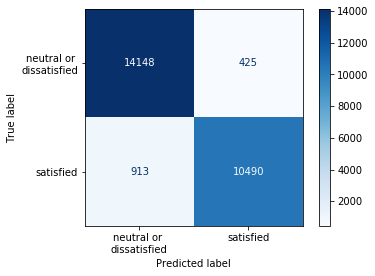

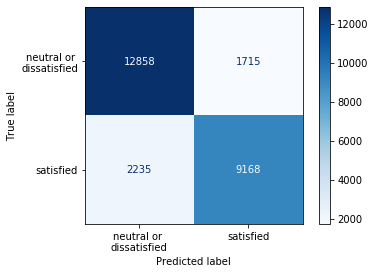

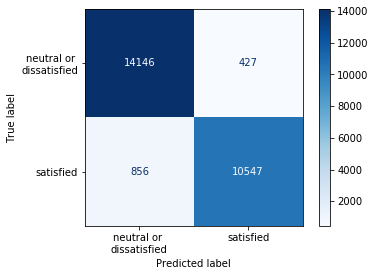

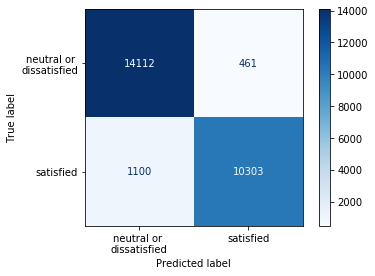

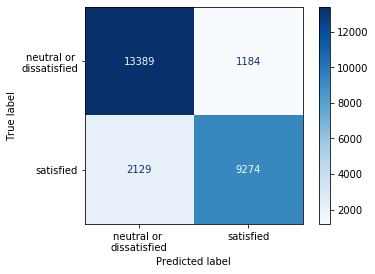

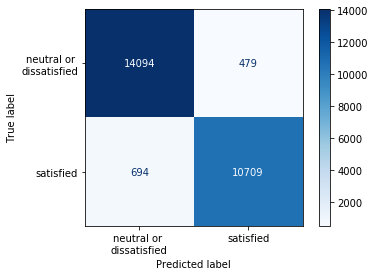

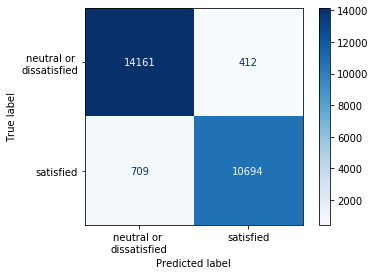

In [11]:

models_roc_auc = []
models_prec_recall = []

for i in range(len(compare_model_names)):
    print("\n***************\n")
    print(compare_model_names[i])
    predictions = compare_models[i].predict(X_test)
    fpr, tpr, thresholds = roc_curve(y_test_bool, predictions)
    auc_val = auc(fpr, tpr)
    models_roc_auc.append([fpr,  tpr, thresholds, auc_val])
    precision, recall, thresholds = precision_recall_curve(y_test_bool, predictions)
    models_prec_recall.append([precision, recall, thresholds])
    print(classification_report(predictions,y_test_bool))
    print(confusion_matrix(predictions,y_test_bool))
    plot_confusion_matrix(compare_models[i], X_test, y_test_bool,
                                 display_labels=['neutral or \ndissatisfied', 'satisfied'],
                                 cmap=plt.cm.Blues, values_format = 'd')
    
    

In [12]:
mlp_model = tf.keras.models.load_model('saved_models/50_50_adam.h5')
predictions = mlp_model.predict_classes(X_test)
fpr_mlp, tpr_mlp, thresholds_mlp = roc_curve(y_test_bool, predictions)
auc_mlp = auc(fpr_mlp, tpr_mlp)
mlp_precision, mlp_recall, mlp_thresholds = precision_recall_curve(y_test_bool, predictions)
print(classification_report(predictions,y_test_bool))
print(confusion_matrix(predictions,y_test_bool))


Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
If using Keras pass *_constraint arguments to layers.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
              precision    recall  f1-score   support

           0       0.97      0.96      0.96     14838
           1       0.94      0.96      0.95     11138

    accuracy                           0.96     25976
   macro avg       0.96      0.96      0.96     25976
weighted avg       0.96      0.96      0.96     25976

[[14176   662]
 [  397 10741]]


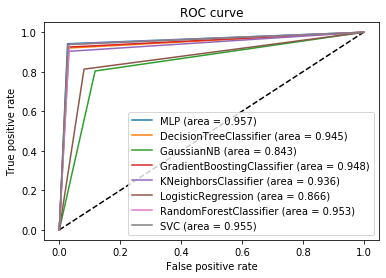

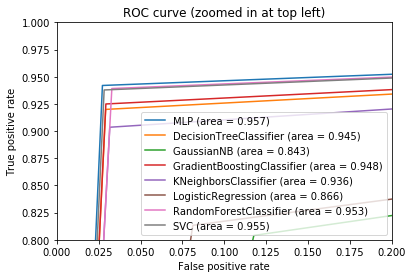

In [13]:
plt.figure(1)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_mlp, tpr_mlp, label='MLP (area = {:.3f})'.format(auc_mlp))
for i in range(len(models_roc_auc)):
    plt.plot(models_roc_auc[i][0], models_roc_auc[i][1], label=compare_model_names[i]+' (area = {:.3f})'.format(models_roc_auc[i][3]))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.show()

plt.figure(2)
plt.xlim(0, 0.2)
plt.ylim(0.8, 1)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_mlp, tpr_mlp, label='MLP (area = {:.3f})'.format(auc_mlp))
for i in range(len(models_roc_auc)):
    plt.plot(models_roc_auc[i][0], models_roc_auc[i][1], label=compare_model_names[i]+' (area = {:.3f})'.format(models_roc_auc[i][3]))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve (zoomed in at top left)')
plt.legend(loc='best')
plt.show()

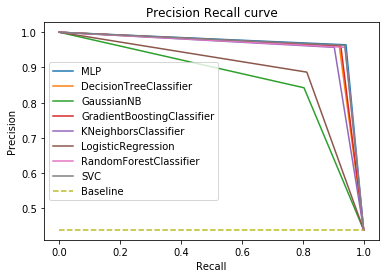

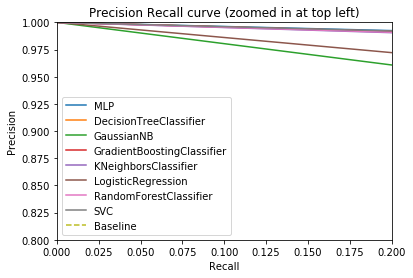

In [14]:
baseline = len(y_test_bool[y_test_bool==1]) / len(y_test_bool)

plt.figure(1)
plt.plot(mlp_recall, mlp_precision, label='MLP')
for i in range(len(models_prec_recall)):
    plt.plot(models_prec_recall[i][1], models_prec_recall[i][0], label=compare_model_names[i])
plt.plot([0, 1], [baseline, baseline], linestyle='--', label='Baseline')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision Recall curve')
plt.legend(loc='best')
plt.show()

plt.figure(2)
plt.xlim(0, 0.2)
plt.ylim(0.8, 1)
plt.plot(mlp_recall, mlp_precision, label='MLP')
for i in range(len(models_roc_auc)):
    plt.plot(models_prec_recall[i][1], models_prec_recall[i][0], label=compare_model_names[i])
plt.plot([0, 1], [baseline, baseline], linestyle='--', label='Baseline')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision Recall curve (zoomed in at top left)')
plt.legend(loc='best')
plt.show()